In [8]:
import os
from utils import *
import optuna

In [9]:
data, usermap, itemmap, users = load_data2()
data_train, data_test, data_val=split_data2(data, 0.2, 0.2)

In [10]:
study_name = "some tricks"
study = optuna.create_study(
    study_name=study_name,
    storage=get_database_url(),
    load_if_exists=True,
    direction="maximize",
)

[I 2024-01-05 19:12:10,137] A new study created in memory with name: some tricks


In [11]:
from Evaluation.Evaluator import EvaluatorHoldout

cutoff_list=[5, 10, 15]

evaluator_validation = EvaluatorHoldout(data_val, cutoff_list=cutoff_list)
evaluator_test = EvaluatorHoldout(data_test, cutoff_list=cutoff_list)

EvaluatorHoldout: Ignoring 2170 (17.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 2568 (20.3%) Users that have less than 1 test interactions


In [12]:
import numpy as np 
import scipy.sparse as sps

profile_length = np.ediff1d(sps.csr_matrix(data_train).indptr)
profile_length, profile_length.shape

(array([33, 29,  2, ...,  6, 19, 52]), (12638,))

In [13]:
block_size = int(len(profile_length)*0.05)
block_size

631

In [14]:
sorted_users = np.argsort(profile_length)
sorted_users

array([ 6826, 10526,  2902, ...,  1469,  9626, 11744], dtype=int64)

In [15]:
for group_id in range(0, 20):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    

Group 0, #users in group 631, average p.len 0.23, median 0.0, min 0, max 1
Group 1, #users in group 631, average p.len 1.00, median 1.0, min 1, max 1
Group 2, #users in group 631, average p.len 1.47, median 1.0, min 1, max 2
Group 3, #users in group 631, average p.len 2.18, median 2.0, min 2, max 3
Group 4, #users in group 631, average p.len 3.11, median 3.0, min 3, max 4
Group 5, #users in group 631, average p.len 4.24, median 4.0, min 4, max 5
Group 6, #users in group 631, average p.len 5.44, median 5.0, min 5, max 6
Group 7, #users in group 631, average p.len 6.77, median 7.0, min 6, max 8
Group 8, #users in group 631, average p.len 8.47, median 8.0, min 8, max 9
Group 9, #users in group 631, average p.len 10.40, median 10.0, min 9, max 12
Group 10, #users in group 631, average p.len 12.79, median 13.0, min 12, max 14
Group 11, #users in group 631, average p.len 15.47, median 15.0, min 14, max 17
Group 12, #users in group 631, average p.len 18.59, median 19.0, min 17, max 20
Group 1

In [17]:
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Recommenders.KNN.ItemKNN_CFCBF_Hybrid_Recommender import ItemKNN_CFCBF_Hybrid_Recommender
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.SLIM.SLIMElasticNetRecommender import SLIMElasticNetRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_BPR_Cython, MatrixFactorization_AsySVD_Cython
from Recommenders.MatrixFactorization.Cython.MatrixFactorizationImpressions_Cython import MatrixFactorization_FunkSVD_Cython
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender

MAP_recommender_per_group = {}

collaborative_recommender_class = {"TopPop": TopPop,
                                   "UserKNNCF": UserKNNCFRecommender,
                                   "ItemKNNCF": ItemKNNCFRecommender,
                                   "P3alpha": P3alphaRecommender,
                                   "RP3beta": RP3betaRecommender,
                                   "PureSVD": PureSVDRecommender,
                                   "NMF": NMFRecommender,
                                   #"FunkSVD": MatrixFactorization_FunkSVD_Cython,
                                   "SLIMBPR": SLIM_BPR_Cython,
                                   }

content_recommender_class = {"ItemKNNCBF": ItemKNNCBFRecommender,
                             "ItemKNNCFCBF": ItemKNN_CFCBF_Hybrid_Recommender
                            }

recommender_object_dict = {}

for label, recommender_class in collaborative_recommender_class.items():
    recommender_object = recommender_class(data_train)
    recommender_object.fit()
    recommender_object_dict[label] = recommender_object

#for label, recommender_class in content_recommender_class.items():
#    recommender_object = recommender_class(URM_train, ICM_genres)
#    recommender_object.fit()
#    recommender_object_dict[label] = recommender_object



TopPopRecommender: URM Detected 484 ( 3.8%) users with no interactions.
TopPopRecommender: URM Detected 313 ( 1.4%) items with no interactions.
UserKNNCFRecommender: URM Detected 484 ( 3.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 313 ( 1.4%) items with no interactions.
Similarity column 12638 (100.0%), 3020.53 column/sec. Elapsed time 4.18 sec
ItemKNNCFRecommender: URM Detected 484 ( 3.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 313 ( 1.4%) items with no interactions.
Similarity column 22222 (100.0%), 2733.02 column/sec. Elapsed time 8.13 sec
P3alphaRecommender: URM Detected 484 ( 3.8%) users with no interactions.
P3alphaRecommender: URM Detected 313 ( 1.4%) items with no interactions.
P3alphaRecommender: Similarity column 22222 (100.0%), 1421.52 column/sec. Elapsed time 15.63 sec
RP3betaRecommender: URM Detected 484 ( 3.8%) users with no interactions.
RP3betaRecommender: URM Detected 313 ( 1.4%) items with no interactions.
RP3betaRecommen

In [18]:
cutoff = 10

for group_id in range(0, 20):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(data_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    
    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]
        

Group 0, #users in group 631, average p.len 0.23, median 0.0, min 0, max 1
EvaluatorHoldout: Ignoring 2568 (20.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 12007 Users
EvaluatorHoldout: Processed 296 (100.0%) in 1.39 sec. Users per second: 213
EvaluatorHoldout: Processed 296 (100.0%) in 1.65 sec. Users per second: 179
EvaluatorHoldout: Processed 296 (100.0%) in 1.48 sec. Users per second: 200
EvaluatorHoldout: Processed 296 (100.0%) in 1.33 sec. Users per second: 222
EvaluatorHoldout: Processed 296 (100.0%) in 1.04 sec. Users per second: 286
EvaluatorHoldout: Processed 296 (100.0%) in 1.38 sec. Users per second: 214
EvaluatorHoldout: Processed 296 (100.0%) in 2.08 sec. Users per second: 142
EvaluatorHoldout: Processed 296 (100.0%) in 1.70 sec. Users per second: 174
Group 1, #users in group 631, average p.len 1.00, median 1.0, min 1, max 1
EvaluatorHoldout: Ignoring 2568 (20.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 1200

In [19]:
result_df

,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.102694,0.102694,0.033612,0.044336,0.044336,0.266594,0.109948,0.050647,0.613312,0.342034,...,1.0,0.613312,1.0,0.002255,5.854305,0.96852,0.006559,0.451531,4.683125,0.290095


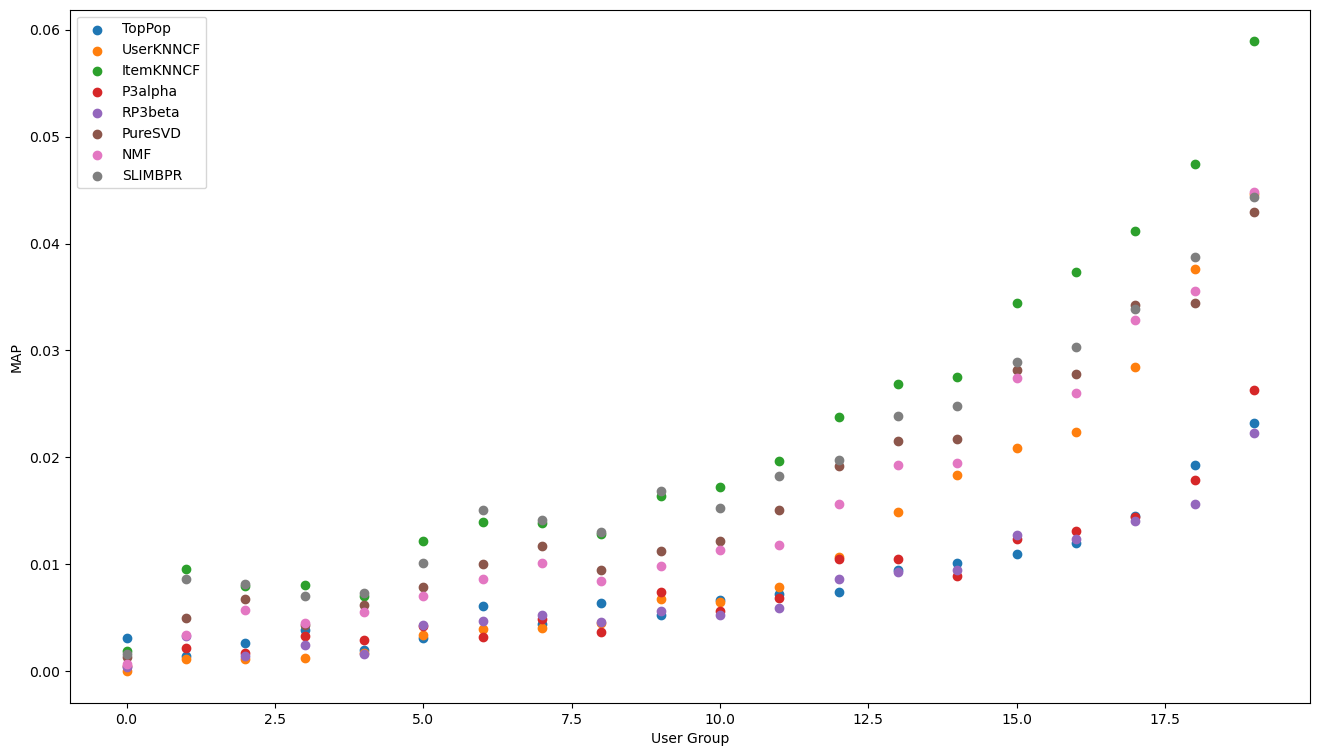

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline  

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()